In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
adata = ad.read_zarr('/mnt/ssd/atlases/Human_Atlas_Harmonised.zarr/')

# Define Func

In [10]:
adata.obs['Dataset_ID'] = adata.obs.Dataset.astype(str) + adata.obs.Sample_ID.astype(str)

In [76]:
from typing import Optional, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from anndata import AnnData

def plot_obs_bar(
    adata: AnnData,
    obs_key: str,
    *,
    count_patients: bool = False,
    dataset_id_key: str = "Dataset_ID",
    sort: bool = True,
    ax: Optional[plt.Axes] = None,
    bar_width_in: float = 0.35,
    bar_gap_in: float = 0.15,
    tallest_bar_in: float = 3.0,
    min_fig_w_in: float = 2.0,
    min_fig_h_in: float = 2.0,
    left: float = 0.12,
    right: float = 0.98,
    bottom: float = 0.28,
    top: float = 0.90,
    rotation: int = 45,
    save_path: Optional[str] = None,
    ct: bool = False
):
    if obs_key not in adata.obs.columns:
        raise KeyError(f"'{obs_key}' not found in adata.obs (available: {list(adata.obs.columns)[:10]}...)")
    if count_patients and dataset_id_key not in adata.obs.columns:
        raise KeyError(f"count_patients=True but '{dataset_id_key}' not found in adata.obs.")

    if count_patients:
        tmp = adata.obs[[obs_key, dataset_id_key]].dropna(subset=[obs_key, dataset_id_key])
        counts = tmp.groupby(obs_key, observed=False)[dataset_id_key].nunique()
        ylabel = f"Nr. of samples"
        title_suffix = " (unique samples)"
        if pd.api.types.is_categorical_dtype(adata.obs[obs_key]) and not sort:
            counts = counts.reindex(adata.obs[obs_key].cat.categories, fill_value=0)
    else:
        cat = adata.obs[obs_key]
        if not pd.api.types.is_categorical_dtype(cat):
            cat = cat.astype("category")
        counts = pd.Series(cat).value_counts(dropna=False)
        if pd.api.types.is_categorical_dtype(adata.obs[obs_key]):
            counts = counts.reindex(adata.obs[obs_key].cat.categories, fill_value=0)
        ylabel = "Nr. of cells"
        title_suffix = " (cells)"

    if sort:
        counts = counts.sort_values(ascending=False)

    n_bars = int(len(counts))
    if n_bars == 0:
        raise ValueError(f"No categories to plot for '{obs_key}'.")

    axes_w_in = max(0.1, n_bars * bar_width_in + (n_bars - 1) * bar_gap_in)
    axes_h_in = max(0.1, tallest_bar_in)

    ax_frac_w = max(1e-3, right - left)
    ax_frac_h = max(1e-3, top - bottom)

    fig_w_in = max(min_fig_w_in, axes_w_in / ax_frac_w)
    fig_h_in = max(min_fig_h_in, axes_h_in / ax_frac_h)

    if ax is None:
        fig, ax = plt.subplots(figsize=(fig_w_in, fig_h_in), constrained_layout=False)
    else:
        fig = ax.figure

    fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top)

    x = np.arange(n_bars)
    inches_per_unit = axes_w_in / n_bars
    bar_width_units = bar_width_in / inches_per_unit

    ax.set_xlim(-0.5, n_bars - 0.5)
    ax.margins(x=0)

    bars = ax.bar(
        x,
        counts.values,
        width=bar_width_units,
        color="salmon" if ct else "0.7" ,
        edgecolor="black",
        linewidth=0.5,
        align="center",
    )

    ymax = float(counts.max()) + (15 if count_patients else 50000)
    if ymax <= 0:
        ymax = 1.0
    ax.set_ylim(0, ymax)

    ax.set_xticks(x, counts.index.astype(str), rotation=rotation, ha="center")
    ax.set_ylabel(ylabel)
    ax.set_xlabel(obs_key)
    ax.set_title(f"")

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    return fig, ax, counts


# Plots

In [6]:
cols_to_plot = [
    'Treatment', 
    'TreatmentType',
    'TreatmentStatus', 
    'Sex', 
    'Dataset', 
    'Technology', 
    'Age',
    'Is_Core',
]

In [51]:
out_path = "/mnt/kkf2/Cell/AG-Saur/KKF2/Daniele/pdac_atlas_figures/supplementary/fig3"

In [56]:
for col in cols_to_plot[:2]:
    print(col)

Treatment
TreatmentType


/tmp/ipykernel_1211473/1469099814.py:41: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(cat):
/tmp/ipykernel_1211473/1469099814.py:44: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs[obs_key]):
/tmp/ipykernel_1211473/1469099814.py:37: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs[obs_key]) and not sort:
/tmp/ipykernel_1211473/1469099814.py:41: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(cat):
/tmp/ipykernel_12

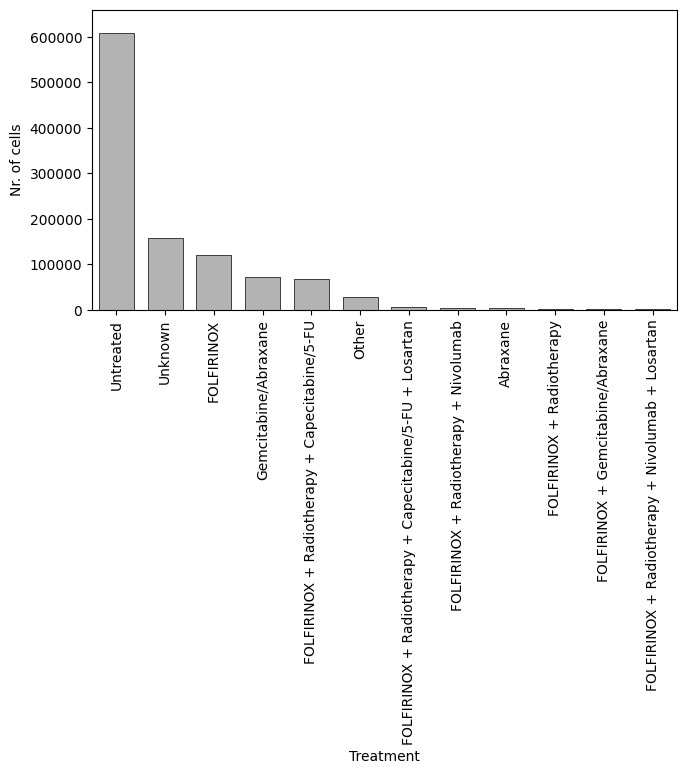

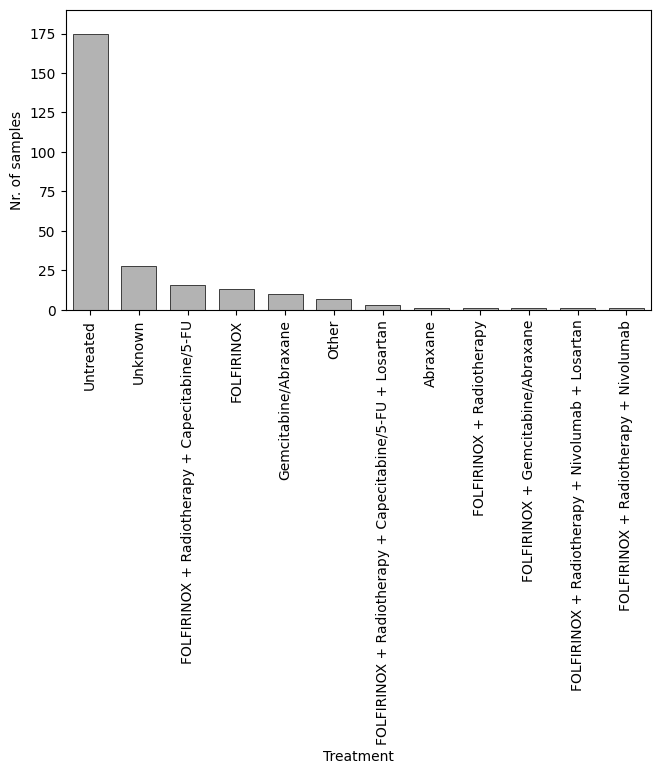

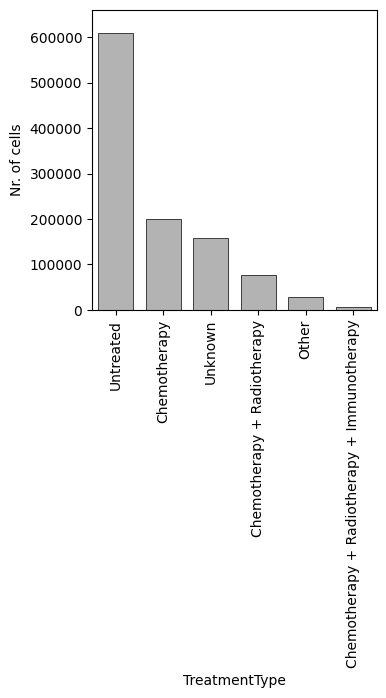

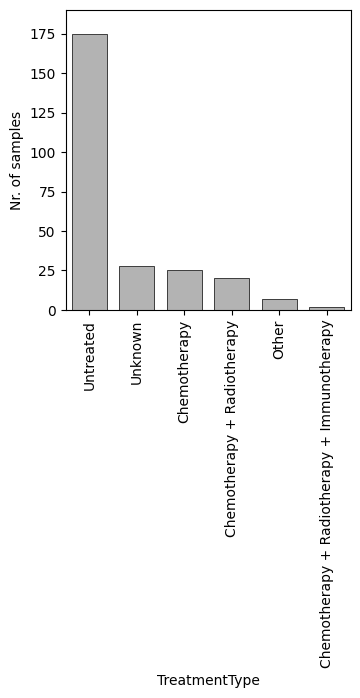

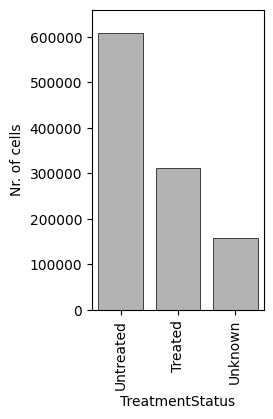

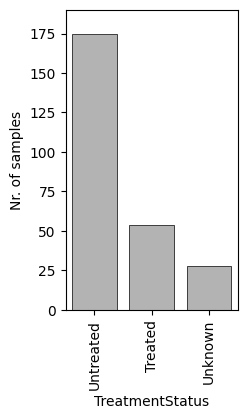

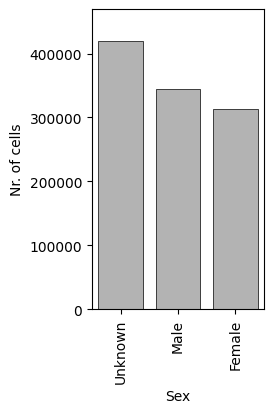

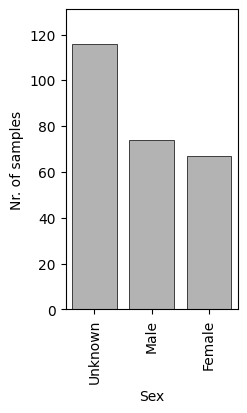

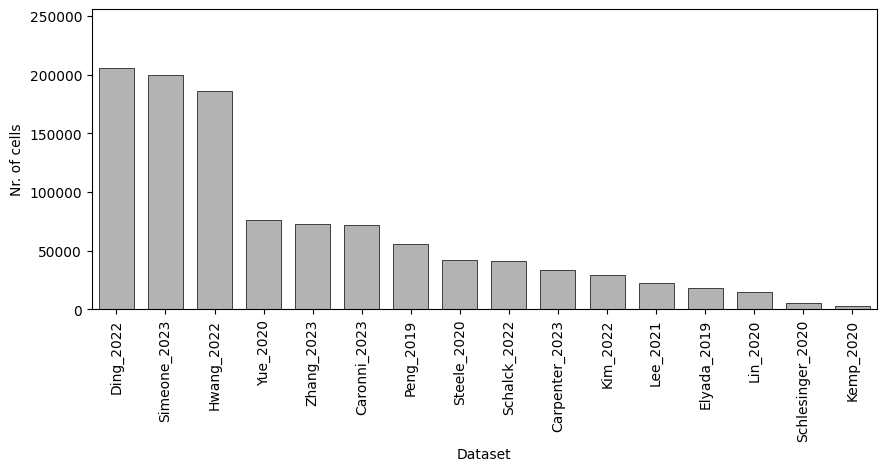

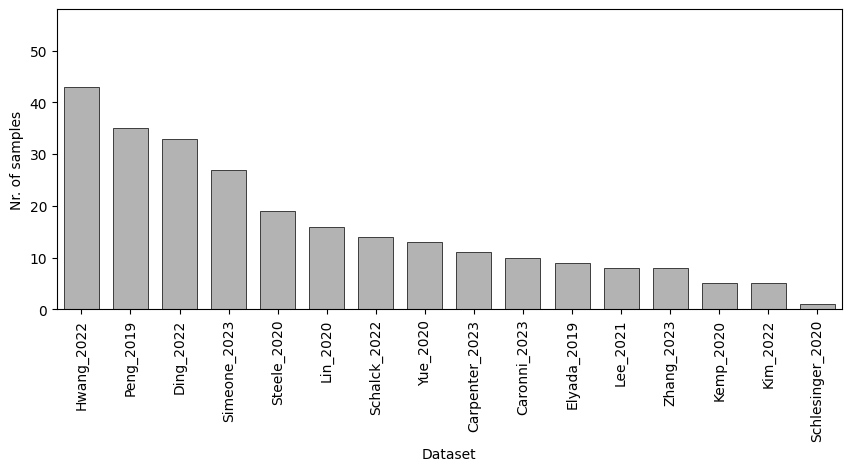

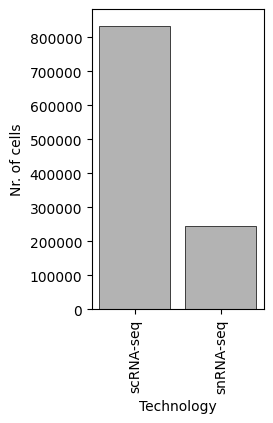

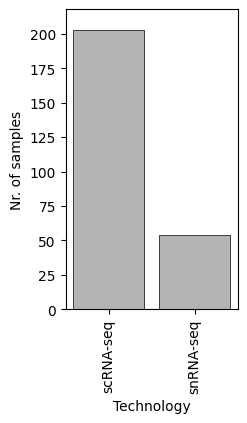

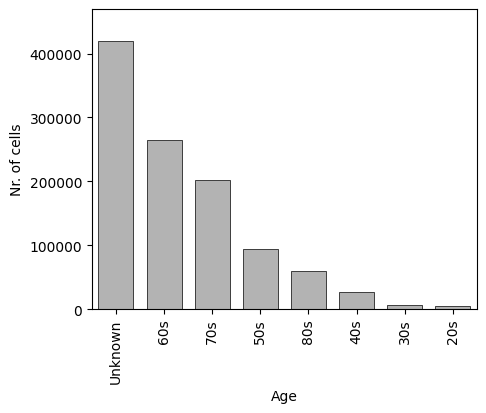

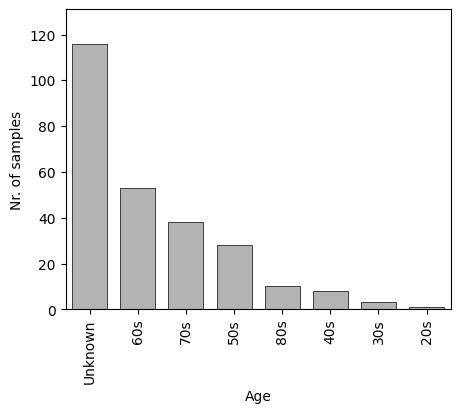

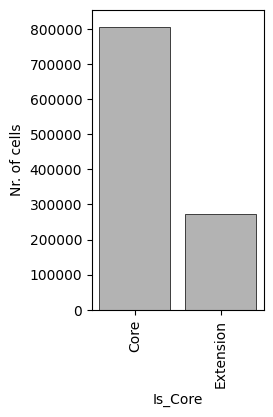

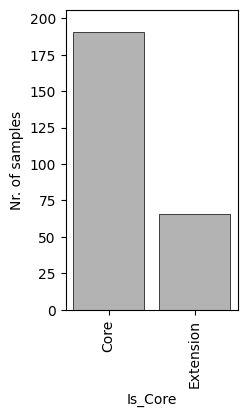

In [73]:
for col in cols_to_plot:
    path1 = os.path.join(out_path, f"{col}_cells_barplot.png")
    path2 = os.path.join(out_path, f"{col}_samples_barplot.png")
    plot_obs_bar(
        adata,
        obs_key = col, 
        rotation=90,
        save_path=path1
    )
    plot_obs_bar(
        adata,
        obs_key = col, 
        rotation=90,
        count_patients=True,
        save_path=path2
    )    

In [ ]:
for mc in adata.obs.Level_2.unique():
    path1 = os.path.join(out_path, f"Level_2_{mc}_states_composition_barplot.png")
    plot_obs_bar(
        adata[adata.obs.Level_2 == mc],
        obs_key = "Level_4", 
        rotation=90,
        ct=True,
        save_path=path1
    )
for mc in adata.obs.Level_3.unique():
    path1 = os.path.join(out_path, f"Level_3_{mc}_states_composition_barplot.png")
    plot_obs_bar(
        adata[adata.obs.Level_3 == mc],
        obs_key = "Level_4", 
        rotation=90,
        ct=True,
        save_path=path1
    )

/tmp/ipykernel_1211473/846729598.py:42: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(cat):
/tmp/ipykernel_1211473/846729598.py:45: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs[obs_key]):
/tmp/ipykernel_1211473/846729598.py:42: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(cat):
/tmp/ipykernel_1211473/846729598.py:45: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs[obs_key]):
/tmp/ipykernel_1211473/846729598.p

# Store results

In [11]:
from typing import Dict, List

dataset_id_key = "Dataset_ID" 

def _counts_for_col(adata, col: str) -> pd.DataFrame:
    """Return a DataFrame indexed by category with columns ['cells','samples'] for one obs column."""
    ser = adata.obs[col]
    if not pd.api.types.is_categorical_dtype(ser):
        ser = ser.astype("category")
    categories = ser.cat.categories
    cells = pd.Series(ser).value_counts(dropna=False)
    cells = cells.reindex(categories, fill_value=0)
    if dataset_id_key in adata.obs.columns:
        tmp = adata.obs[[col, dataset_id_key]].dropna(subset=[col, dataset_id_key])
        samples = tmp.groupby(col, observed=False)[dataset_id_key].nunique()
        samples = samples.reindex(categories, fill_value=0)
    else:
        samples = pd.Series(0, index=categories, dtype=int)

    out = pd.DataFrame({"cells": cells.astype(int), "samples": samples.astype(int)})
    out.index.name = "category"
    return out

frames: List[pd.DataFrame] = []
for col in cols_to_plot:
    df_col = _counts_for_col(adata, col)
    df_col.insert(0, "obs", col)
    frames.append(df_col.reset_index())

df_dist_long = pd.concat(frames, ignore_index=True)
df_dist = df_dist_long.set_index(["obs", "category"]).sort_index()

/tmp/ipykernel_1255363/3242612199.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(ser):
/tmp/ipykernel_1255363/3242612199.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(ser):
/tmp/ipykernel_1255363/3242612199.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(ser):
/tmp/ipykernel_1255363/3242612199.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(ser):
/tmp/ipykernel_1255363/3242612199.py:8: DeprecationWarni

In [15]:
out_path = "/home/daniele/Code/github_synced/PDAC/supplementary_data/human"
out_file = os.path.join(out_path, "metadata_category_distributions.csv")

df_dist.to_csv(out_file)
print(f"Saved combined distributions to: {out_file}")

Saved combined distributions to: /home/daniele/Code/github_synced/PDAC/supplementary_data/human/metadata_category_distributions.csv
